<left><img width=25% src="img/gw_monogram_2c.png"></left>

# Lecture 3: Linear Regression

### ECE6210 Machine Intelligence

__Armin Mehrabian__<br>The George Washington Universiry

# Announcements

* 

# Recall: Components of a Supervised Machine Learning Problem

To apply supervised learning, we define a dataset and a learning algorithm.

$$ \underbrace{\text{Dataset}}_\text{Features, Attributes, Targets} + \underbrace{\text{Learning Algorithm}}_\text{Model Class + Objective + Optimizer } \to \text{Predictive Model} $$

The output is a predictive model that maps inputs to targets. For instance, it can predict targets on new inputs.

# Part 1: Calculus Review

Before we present our first supervised learning algorithm, we will do a quick calculus review.

# Optimizer: Notation

At a high-level an optimizer takes 
* an objective $J$ (also called a loss function) and 
* a model class $\mathcal{M}$ 

It outputs a model $f \in \mathcal{M}$ with the smallest value of the objective $J$.

\begin{align*}
\min_{f \in \mathcal{M}} J(f)
\end{align*}

Intuitively, this is the function that bests "fits" the data on the training dataset $\mathcal{D} = \{(x^{(i)}, y^{(i)}) \mid i = 1,2,...,n\}$.

We will use the a quadratic function as our running example for an objective $J$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]

def quadratic_function(theta):
    """The cost function, J(theta)."""
    return 0.5*(2*theta-1)**2

We can visualize it.

In [2]:
# First construct a grid of theta1 parameter pairs and their corresponding
# cost function values.
thetas = np.linspace(-0.2,1,10)
f_vals = quadratic_function(thetas[:,np.newaxis])

plt.plot(thetas, f_vals)
plt.xlabel('Theta')
plt.ylabel('Objective value')
plt.title('Simple quadratic function')

Text(0.5, 1.0, 'Simple quadratic function')

# Calculus Review: Derivatives

Recall that the derivative $$\frac{d f(\theta_0)}{d \theta}$$ of a univariate function $f : \mathbb{R} \to \mathbb{R}$ is the instantaneous rate of change of the function $f(\theta)$ with respect to its parameter $\theta$ at the point $\theta_0$.

In [3]:
def quadratic_derivative(theta):
    return (2*theta-1)*2

df0 = quadratic_derivative(np.array([[0]])) # derivative at zero
f0 = quadratic_function(np.array([[0]]))
line_length = 0.2

plt.plot(thetas, f_vals)
plt.annotate('', xytext=(0-line_length, f0-line_length*df0), xy=(0+line_length, f0+line_length*df0),
             arrowprops={'arrowstyle': '-', 'lw': 1.5}, va='center', ha='center')
plt.xlabel('Theta')
plt.ylabel('Objective value')
plt.title('Simple quadratic function')

Text(0.5, 1.0, 'Simple quadratic function')

Text(0.5, 1.0, 'Simple quadratic function')

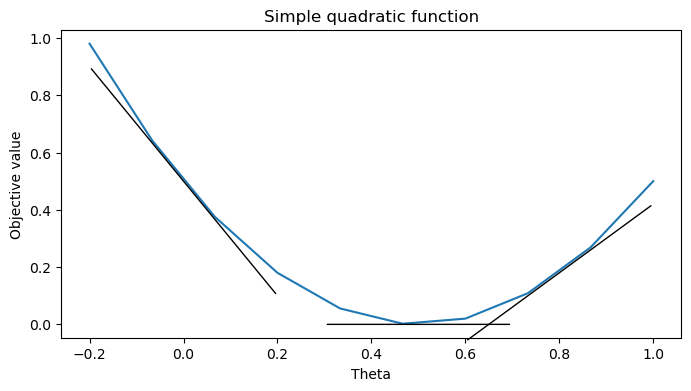

In [4]:
pts = np.array([[0, 0.5, 0.8]]).reshape((3,1))
df0s = quadratic_derivative(pts)
f0s = quadratic_function(pts)

plt.plot(thetas, f_vals)
for pt, f0, df0 in zip(pts.flatten(), f0s.flatten(), df0s.flatten()): 
    plt.annotate('', xytext=(pt-line_length, f0-line_length*df0), xy=(pt+line_length, f0+line_length*df0),
             arrowprops={'arrowstyle': '-', 'lw': 1}, va='center', ha='center')
plt.xlabel('Theta')
plt.ylabel('Objective value')
plt.title('Simple quadratic function')

# Calculus Review: Partial Derivatives

The partial derivative $$\frac{\partial f(\theta)}{\partial \theta_j}$$ of a multivariate function $f : \mathbb{R}^d \to \mathbb{R}$ is the derivative of $f$ with respect to $\theta_j$ while all the other dimensions $\theta_k$ for $k\neq j$ are fixed.

# Calculus Review: The Gradient

The gradient $\nabla f$ is the vector of all the partial derivatives:

$$ \nabla f (\theta) = \begin{bmatrix}
\frac{\partial f(\theta)}{\partial \theta_1} \\
\frac{\partial f(\theta)}{\partial \theta_2} \\
\vdots \\
\frac{\partial f(\theta)}{\partial \theta_d}
\end{bmatrix}.$$

The $j$-th entry of the vector $\nabla f (\theta)$ is the partial derivative $\frac{\partial f(\theta)}{\partial \theta_j}$ of $f$ with respect to the $j$-th component of $\theta$.

We will use a quadratic function as a running example.

Let's visualize this function.

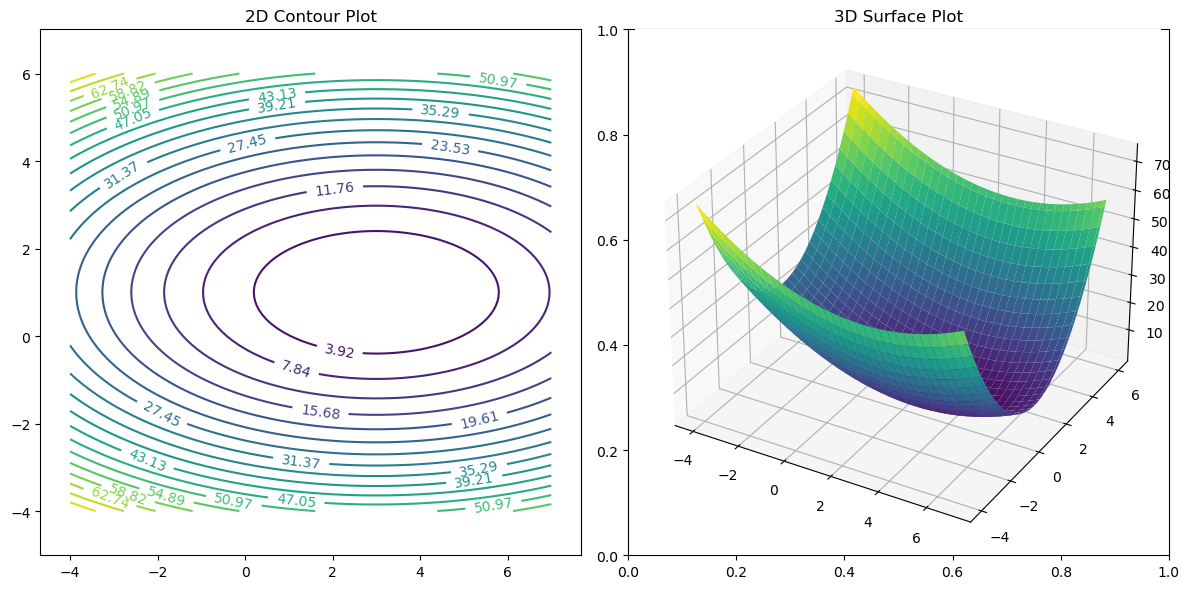

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def quadratic_function2d(theta0, theta1):
    """Quadratic objective function, J(theta0, theta1).
    
    The inputs theta0, theta1 are 2d arrays and we evaluate
    the objective at each value theta0[i,j], theta1[i,j].
    We implement it this way so it's easier to plot the
    level curves of the function in 2d.

    Parameters:
    theta0 (np.array): 2d array of first parameter theta0
    theta1 (np.array): 2d array of second parameter theta1
    
    Returns:
    fvals (np.array): 2d array of objective function values
        fvals is the same dimension as theta0 and theta1.
        fvals[i,j] is the value at theta0[i,j] and theta1[i,j].
    """
    theta0 = np.atleast_2d(np.asarray(theta0))
    theta1 = np.atleast_2d(np.asarray(theta1))
    return 0.5*((2*theta1-2)**2 + (theta0-3)**2)


theta0_grid = np.linspace(-4, 7, 101)
theta1_grid = np.linspace(-4, 6, 101)
J_grid = quadratic_function2d(theta0_grid[np.newaxis,:], theta1_grid[:,np.newaxis])

X, Y = np.meshgrid(theta0_grid, theta1_grid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 2D Contour plot with custom axis limits and levels
contour_levels = np.linspace(np.min(J_grid), np.max(J_grid), 20)  # You can modify the number of levels
contours = ax1.contour(X, Y, J_grid, levels=contour_levels)
ax1.clabel(contours)
ax1.axis('equal')
ax1.set_title('2D Contour Plot')
ax1.set_xlim([-4, 7])  # Explicitly setting x-axis limits
ax1.set_ylim([-4, 6])  # Explicitly setting y-axis limits

# 3D plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, J_grid, cmap='viridis')
ax2.set_title('3D Surface Plot')

plt.tight_layout()


Let's write down the derivative of the quadratic function.

In [6]:
def quadratic_derivative2d(theta0, theta1):
    """Derivative of quadratic objective function.
    
    The inputs theta0, theta1 are 1d arrays and we evaluate
    the derivative at each value theta0[i], theta1[i].

    Parameters:
    theta0 (np.array): 1d array of first parameter theta0
    theta1 (np.array): 1d array of second parameter theta1
    
    Returns:
    grads (np.array): 2d array of partial derivatives
        grads is of the same size as theta0 and theta1
        along first dimension and of size
        two along the second dimension.
        grads[i,j] is the j-th partial derivative 
        at input theta0[i], theta1[i].
    """
    # this is the gradient of 0.5*((2*theta1-2)**2 + (theta0-3)**2)
    grads = np.stack([theta0-3, (2*theta1-2)*2], axis=1)
    grads = grads.reshape([len(theta0), 2])
    return grads

We can visualize the derivative.

(-4.0, 7.0, -1.0, 4.0)

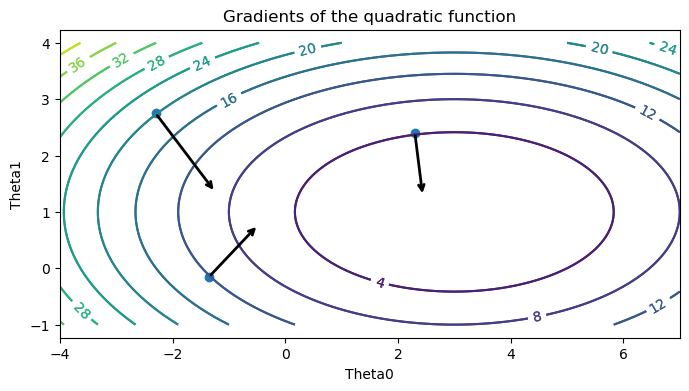

In [7]:
theta0_grid = np.linspace(-4,7,101)
theta1_grid = np.linspace(-1,4,101)
theta_grid = theta0_grid[np.newaxis,:], theta1_grid[:,np.newaxis]
J_grid = quadratic_function2d(theta0_grid[np.newaxis,:], theta1_grid[:,np.newaxis])

X, Y = np.meshgrid(theta0_grid, theta1_grid)
contours = plt.contour(X, Y, J_grid, 10)
plt.clabel(contours)
plt.axis('equal')
theta0_pts, theta1_pts = np.array([2.3, -1.35, -2.3]), np.array([2.4, -0.15, 2.75])
dfs = quadratic_derivative2d(theta0_pts, theta1_pts)
line_length = 0.2

contours = plt.contour(X, Y, J_grid, 10)
for theta0_pt, theta1_pt, df0 in zip(theta0_pts, theta1_pts, dfs):
    plt.annotate('', xytext=(theta0_pt, theta1_pt), 
                     xy=(theta0_pt-line_length*df0[0], theta1_pt-line_length*df0[1]),
                     arrowprops={'arrowstyle': '->', 'lw': 2}, va='center', ha='center')
plt.scatter(theta0_pts, theta1_pts)
plt.clabel(contours)
plt.xlabel('Theta0')
plt.ylabel('Theta1')
plt.title('Gradients of the quadratic function')
plt.axis('equal')

<left><img width=25% src="img/gw_monogram_2c.png"></left>
# Part 1b: Gradient Descent

Next, we will use gradients to define an important algorithm called *gradient descent*.

# Calculus Review: The Gradient

The gradient $\nabla_\theta f$ further extends the derivative to multivariate functions $f : \mathbb{R}^d \to \mathbb{R}$, and is defined at a point $\theta_0$ as

$$ \nabla_\theta f (\theta_0) = \begin{bmatrix}
\frac{\partial f(\theta_0)}{\partial \theta_1} \\
\frac{\partial f(\theta_0)}{\partial \theta_2} \\
\vdots \\
\frac{\partial f(\theta_0)}{\partial \theta_d}
\end{bmatrix}.$$

The $j$-th entry of the vector $\nabla_\theta f (\theta_0)$ is the partial derivative $\frac{\partial f(\theta_0)}{\partial \theta_j}$ of $f$ with respect to the $j$-th component of $\theta$.

(-4.0, 7.0, -1.0, 4.0)

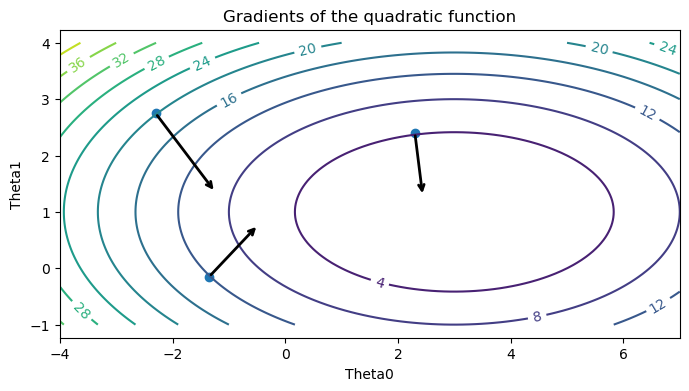

In [8]:
theta0_pts, theta1_pts = np.array([2.3, -1.35, -2.3]), np.array([2.4, -0.15, 2.75])
dfs = quadratic_derivative2d(theta0_pts, theta1_pts)
line_length = 0.2

contours = plt.contour(X, Y, J_grid, 10)
for theta0_pt, theta1_pt, df0 in zip(theta0_pts, theta1_pts, dfs):
    plt.annotate('', xytext=(theta0_pt, theta1_pt), 
                     xy=(theta0_pt-line_length*df0[0], theta1_pt-line_length*df0[1]),
                     arrowprops={'arrowstyle': '->', 'lw': 2}, va='center', ha='center')
plt.scatter(theta0_pts, theta1_pts)
plt.clabel(contours)
plt.xlabel('Theta0')
plt.ylabel('Theta1')
plt.title('Gradients of the quadratic function')
plt.axis('equal')

# Gradient Descent: Intuition

Gradient descent is a very common optimization algorithm used in machine learning.

The intuition behind gradient descent is to repeatedly obtain the gradient to determine the direction in which the function decreases most steeply and take a step in that direction.

# Gradient Descent: Notation
More formally, if we want to optimize $J(\theta)$, we start with an initial guess $\theta_0$ for the parameters and repeat the following update until $\theta$ is no longer changing:
$$ \theta_i := \theta_{i-1} - \alpha \cdot \nabla J(\theta_{i-1}). $$

In code, this method may look as follows:
```python
theta, theta_prev = random_initialization()
while norm(theta - theta_prev) > convergence_threshold:
    theta_prev = theta
    theta = theta_prev - step_size * gradient(theta_prev)
```
In the above algorithm, we stop when $||\theta_i - \theta_{i-1}||$ is small.

It's easy to implement this function in `numpy`.

In [9]:
convergence_threshold = 2e-1
step_size = 2e-1
theta, theta_prev = np.array([[-2], [3]]), np.array([[0], [0]])
opt_pts = [theta.flatten()]
opt_grads = []

while np.linalg.norm(theta - theta_prev) > convergence_threshold:
    # we repeat this while the value of the function is decreasing
    theta_prev = theta
    gradient = quadratic_derivative2d(*theta).reshape([2,1])
    theta = theta_prev - step_size * gradient
    opt_pts += [theta.flatten()]
    opt_grads += [gradient.flatten()]

We can now visualize gradient descent.

(-4.0, 7.0, -1.0, 4.0)

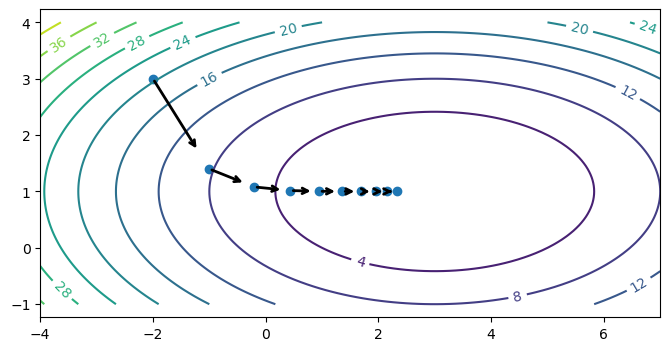

In [10]:
opt_pts = np.array(opt_pts)
opt_grads = np.array(opt_grads)

contours = plt.contour(X, Y, J_grid, 10)
plt.clabel(contours)
plt.scatter(opt_pts[:,0], opt_pts[:,1])

for opt_pt, opt_grad in zip(opt_pts, opt_grads):
    plt.annotate('', xytext=(opt_pt[0], opt_pt[1]), 
                 xy=(opt_pt[0]-0.8*step_size*opt_grad[0], opt_pt[1]-0.8*step_size*opt_grad[1]),
                 arrowprops={'arrowstyle': '->', 'lw': 2}, va='center', ha='center')

plt.axis('equal')

<left><img width=25% src="img/gw_monogram_2c.png"></left>
# Part 2: Gradient Descent in Linear Models

Let's now use gradient descent to derive a supervised learning algorithm for linear models.

# Review: Gradient Descent
If we want to optimize $J(\theta)$, we start with an initial guess $\theta_0$ for the parameters and repeat the following update:
$$ \theta_i := \theta_{i-1} - \alpha \cdot \nabla_\theta J(\theta_{i-1}). $$

As code, this method may look as follows:
```python
theta, theta_prev = random_initialization()
while norm(theta - theta_prev) > convergence_threshold:
    theta_prev = theta
    theta = theta_prev - step_size * gradient(theta_prev)
```

# Review: Linear Model Family

Recall that a linear model has the form
\begin{align*}
y & = \theta_0 + \theta_1 \cdot x_1 + \theta_2 \cdot x_2 + ... + \theta_d \cdot x_d
\end{align*}
where $x \in \mathbb{R}^d$ is a vector of features and $y$ is the target. The $\theta_j$ are the *parameters* of the model.

By using the notation $x_0 = 1$, we can represent the model in a vectorized form
$$ f_\theta(x) = \sum_{j=0}^d \theta_j \cdot x_j = \theta^\top x. $$

Let's define our model in Python.

In [11]:
def f(X, theta):
    """The linear model we are trying to fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional data matrix
    
    Returns:
    y_pred (np.array): n-dimensional vector of predicted targets
    """
    return X.dot(theta)

# An Objective: Mean Squared Error

We pick $\theta$ to minimize the mean squared error (MSE). Slight variants of this objective are also known as the residual sum of squares (RSS) or the sum of squared residuals (SSR).
$$J(\theta)= \frac{1}{2n} \sum_{i=1}^n(y^{(i)}-\theta^\top x^{(i)})^2$$
In other words, we are looking for the best compromise in $\theta$ over all the data points.

Let's implement the mean squared error.

In [12]:
def mean_squared_error(theta, X, y):
    """The cost function, J, describing the goodness of fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    """
    return 0.5*np.mean((y-f(X, theta))**2)

# Mean Squared Error: Partial Derivatives

Let's work out the derivatives for $\frac{1}{2} \left( f_\theta(x^{(i)}) - y^{(i)} \right)^2,$ the MSE of a linear model $f_\theta$ for one training example $(x^{(i)}, y^{(i)})$, which we denote $J^{(i)}(\theta)$.

\begin{align*}
\frac{\partial}{\partial \theta_j} J^{(i)}(\theta) & = \frac{\partial}{\partial \theta_j} \left(\frac{1}{2} \left( f_\theta(x^{(i)}) - y^{(i)} \right)^2\right) \\
& = \left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot \frac{\partial}{\partial \theta_j} \left( f_\theta(x^{(i)}) - y^{(i)} \right) \\
& = \left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot \frac{\partial}{\partial \theta_j} \left( \sum_{k=0}^d \theta_k \cdot x^{(i)}_k - y^{(i)} \right) \\
& = \left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}_j
\end{align*}

# Mean Squared Error: The Gradient

We can use this derivation to obtain an expression for the gradient of the MSE for a linear model

\begin{align*}
\small
{\tiny \nabla_\theta J^{(i)} (\theta)} = \begin{bmatrix}
\frac{\partial J^{(i)}(\theta)}{\partial \theta_0} \\
\frac{\partial J^{(i)}(\theta)}{\partial \theta_1} \\
\vdots \\
\frac{\partial J^{(i)}(\theta)}{\partial \theta_d}
\end{bmatrix}
=
\begin{bmatrix}
\left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}_0 \\
\left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}_1 \\
\vdots \\
\left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}_d
\end{bmatrix}
=
\left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}
\end{align*}

Note that the MSE over the entire dataset is $J(\theta) = \frac{1}{n}\sum_{i=1}^n J^{(i)}(\theta)$. Therefore:

\begin{align*}
\nabla_\theta J (\theta) = \begin{bmatrix}
\frac{\partial J(\theta)}{\partial \theta_0} \\
\frac{\partial J(\theta)}{\partial \theta_1} \\
\vdots \\
\frac{\partial J(\theta)}{\partial \theta_d}
\end{bmatrix}
=
\frac{1}{n}\sum_{i=1}^n
\begin{bmatrix}
\frac{\partial J^{(i)}(\theta)}{\partial \theta_0} \\
\frac{\partial J^{(i)}(\theta)}{\partial \theta_1} \\
\vdots \\
\frac{\partial J^{(i)}(\theta)}{\partial \theta_d}
\end{bmatrix}
=
\frac{1}{n} \sum_{i=1}^n \left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}
\end{align*}

Let's implement the gradient.

In [13]:
def mse_gradient(theta, X, y):
    """The gradient of the cost function.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    
    Returns:
    grad (np.array): d-dimensional gradient of the MSE
    """
    return np.mean((f(X, theta) - y) * X.T, axis=1)

# The UCI Diabetes Dataset

In this section, we are going to again use the UCI Diabetes Dataset.
* For each patient we have a access to their BMI and an estimate of diabetes risk (from 0-400).
* We are interested in understanding how BMI affects an individual's diabetes risk.

Text(0, 0.5, 'Diabetes Risk')

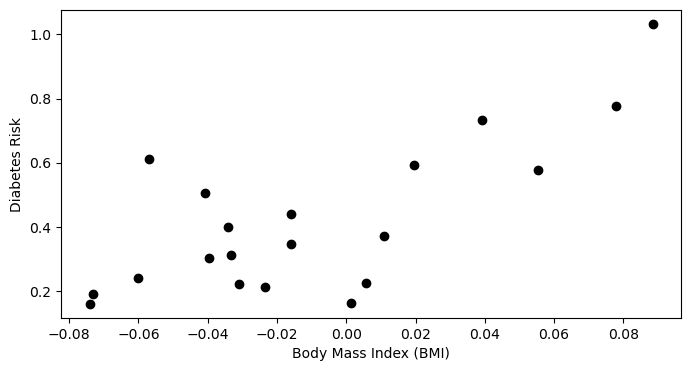

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]

import numpy as np
import pandas as pd
from sklearn import datasets

# Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)

# add an extra column of onens
X['one'] = 1

# Collect 20 data points and only use bmi dimension
X_train = X.iloc[-20:].loc[:, ['bmi', 'one']]
y_train = y.iloc[-20:] / 300

plt.scatter(X_train.loc[:,['bmi']], y_train,  color='black')
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Diabetes Risk')

# Gradient Descent for Linear Regression

Putting this together with the gradient descent algorithm, we obtain a learning method for training linear models.


```python
theta, theta_prev = random_initialization()
while abs(J(theta) - J(theta_prev)) > conv_threshold:
    theta_prev = theta
    theta = theta_prev - step_size * (f(x, theta)-y) * x
```

This update rule is also known as the Least Mean Squares (LMS) or Widrow-Hoff learning rule.

In [15]:
threshold = 1e-3
step_size = 4e-1
theta, theta_prev = np.array([2,1]), np.ones(2,)
opt_pts = [theta]
opt_grads = []
iter = 0

while np.linalg.norm(theta - theta_prev) > threshold:
    if iter % 100 == 0:
        print('Iteration %d. MSE: %.6f' % (iter, mean_squared_error(theta, X_train, y_train)))
    theta_prev = theta
    gradient = mse_gradient(theta, X_train, y_train)
    theta = theta_prev - step_size * gradient
    opt_pts += [theta]
    opt_grads += [gradient]
    iter += 1

Iteration 0. MSE: 0.171729
Iteration 100. MSE: 0.014765
Iteration 200. MSE: 0.014349
Iteration 300. MSE: 0.013997
Iteration 400. MSE: 0.013701


Text(0, 0.5, 'Diabetes Risk')

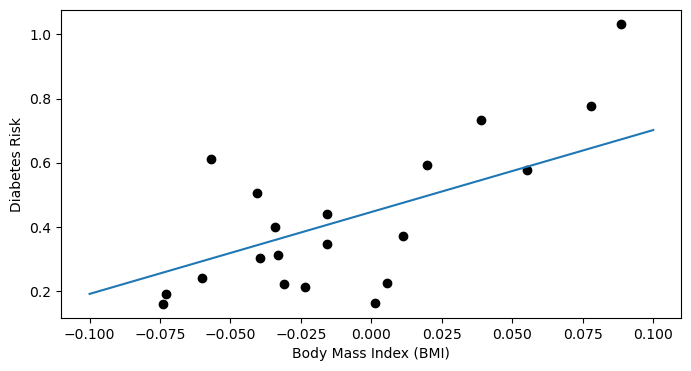

In [16]:
x_line = np.stack([np.linspace(-0.1, 0.1, 10), np.ones(10,)])
y_line = opt_pts[-1].dot(x_line)

plt.scatter(X_train.loc[:,['bmi']], y_train,  color='black')
plt.plot(x_line[0], y_line)
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Diabetes Risk')

<left><img width=25% src="img/gw_monogram_2c.png"></left>
# Part 3: Ordinary Least Squares

In practice, there is a more effective way than gradient descent to find linear model parameters.

This method will produce our first non-toy algorithm: Ordinary Least Squares.

# Review: The Gradient

The gradient $\nabla_\theta f$ further extends the derivative to multivariate functions $f : \mathbb{R}^d \to \mathbb{R}$, and is defined at a point $\theta_0$ as

$$ \nabla_\theta f (\theta_0) = \begin{bmatrix}
\frac{\partial f(\theta_0)}{\partial \theta_1} \\
\frac{\partial f(\theta_0)}{\partial \theta_2} \\
\vdots \\
\frac{\partial f(\theta_0)}{\partial \theta_d}
\end{bmatrix}.$$

In other words, the $j$-th entry of the vector $\nabla_\theta f (\theta_0)$ is the partial derivative $\frac{\partial f(\theta_0)}{\partial \theta_j}$ of $f$ with respect to the $j$-th component of $\theta$.

# The UCI Diabetes Dataset

In this section, we are going to again use the UCI Diabetes Dataset.
* For each patient we have a access to a measurement of their body mass index (BMI) and a quantiative diabetes risk score (from 0-300). 
* We are interested in understanding how BMI affects an individual's diabetes risk.

Text(0, 0.5, 'Diabetes Risk')

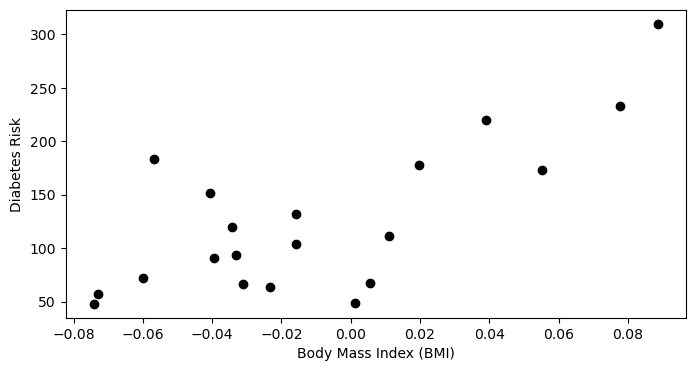

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]

import numpy as np
import pandas as pd
from sklearn import datasets

# Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)

# add an extra column of onens
X['one'] = 1

# Collect 20 data points
X_train = X.iloc[-20:]
y_train = y.iloc[-20:]

plt.scatter(X_train.loc[:,['bmi']], y_train,  color='black')
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Diabetes Risk')

# Notation: Design Matrix

<!-- Suppose that we have a dataset of size $n$ (e.g., $n$ patients), indexed by $i=1,2,...,n$. Each $x^{(i)}$ is a vector of $d$ features. -->

Machine learning algorithms are most easily defined in the language of linear algebra. Therefore, it will be useful to represent the entire dataset as one matrix $X \in \mathbb{R}^{n \times d}$, of the form:

$$ X = \begin{bmatrix}
x^{(1)}_1 & x^{(1)}_2 & \ldots & x^{(1)}_d \\
x^{(2)}_1 & x^{(2)}_2 & \ldots & x^{(2)}_d \\
\vdots \\
x^{(n)}_1 & x^{(n)}_2 & \ldots & x^{(n)}_d
\end{bmatrix}
=
\begin{bmatrix}
- & (x^{(1)})^\top & - \\
- & (x^{(2)})^\top & - \\
& \vdots & \\
- & (x^{(n)})^\top & - \\
\end{bmatrix}
.$$

We can view the design matrix for the diabetes dataset.

In [18]:
X_train.head()

age       sex       bmi        bp        s1        s2        s3  \
422 -0.078165  0.050680  0.077863  0.052858  0.078236  0.064447  0.026550   
423  0.009016  0.050680 -0.039618  0.028758  0.038334  0.073529 -0.072854   
424  0.001751  0.050680  0.011039 -0.019442 -0.016704 -0.003819 -0.047082   
425 -0.078165 -0.044642 -0.040696 -0.081413 -0.100638 -0.112795  0.022869   
426  0.030811  0.050680 -0.034229  0.043666  0.057597  0.068831 -0.032356   

           s4        s5        s6  one  
422 -0.002592  0.040673 -0.009362    1  
423  0.108111  0.015568 -0.046641    1  
424  0.034309  0.024055  0.023775    1  
425 -0.076395 -0.020292 -0.050783    1  
426  0.057557  0.035459  0.085907    1

# Notation: Target Vector


Similarly, we can vectorize the target variables into a vector $y \in \mathbb{R}^n$ of the form
$$ y = \begin{bmatrix}
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(n)}
\end{bmatrix}.$$

# Squared Error in Matrix Form

Recall that we may fit a linear model by choosing $\theta$ that minimizes the squared error:
$$J(\theta)=\frac{1}{2}\sum_{i=1}^n(y^{(i)}-\theta^\top x^{(i)})^2$$

We can write this sum in matrix-vector form as:
$$J(\theta) = \frac{1}{2} (y-X\theta)^\top(y-X\theta) = \frac{1}{2} \|y-X\theta\|^2,$$
where $X$ is the design matrix and $\|\cdot\|$ denotes the Euclidean norm.

# The Gradient of the Squared Error

We can compute the gradient of the mean squared error as follows.

\begin{align*}
\nabla_\theta J(\theta) 
& = \nabla_\theta \frac{1}{2} (X \theta - y)^\top  (X \theta - y) \\
& = \frac{1}{2} \nabla_\theta \left( (X \theta)^\top  (X \theta) - (X \theta)^\top y - y^\top (X \theta) + y^\top y \right) \\
& = \frac{1}{2} \nabla_\theta \left( \theta^\top  (X^\top X) \theta - 2(X \theta)^\top y \right) \\
& = \frac{1}{2} \left( 2(X^\top X) \theta - 2X^\top y \right) \\
& = (X^\top X) \theta - X^\top y
\end{align*}

We used the facts that $a^\top b = b^\top a$ (line 3), that $\nabla_x b^\top x = b$ (line 4), and that $\nabla_x x^\top A x = 2 A x$ for a symmetric matrix $A$ (line 4).

# Normal Equations

<!-- We know from calculus that a function is minimized when its derivative is set to zero. In our case, our objective function is a (multivariate) quadratic; hence it only has one minimum, which is the global minimum.
 -->
Setting the above derivative to zero, we obtain the *normal equations*:
$$ (X^\top X) \theta = X^\top y.$$

Hence, the value $\theta^*$ that minimizes this objective is given by:
$$ \theta^* = (X^\top X)^{-1} X^\top y.$$

Note that we assumed that the matrix $(X^\top X)$ is invertible; we will soon see a simple way of dealing with non-invertible matrices.

Let's apply the normal equations.

In [19]:
import numpy as np

theta_best = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
theta_best_df = pd.DataFrame(data=theta_best[np.newaxis, :], columns=X.columns)
theta_best_df

age         sex        bmi         bp            s1            s2  \
0 -3.797822  204.775932 -64.275792 -263.01616  14008.122523 -11802.044811   

            s3           s4           s5          s6         one  
0 -5893.847369 -1137.012428 -2737.876706 -394.034371  155.705025

We can now use our estimate of theta to compute predictions for 3 new data points.

In [20]:
# Collect 3 data points for testing
X_test = X.iloc[:3]
y_test = y.iloc[:3]

# generate predictions on the new patients
y_test_pred = X_test.dot(theta_best)

Let's visualize these predictions.

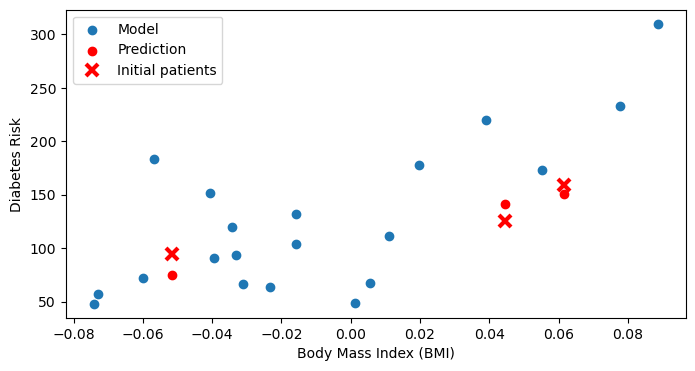

In [21]:
# visualize the results
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Diabetes Risk')
plt.scatter(X_train.loc[:, ['bmi']], y_train)
plt.scatter(X_test.loc[:, ['bmi']], y_test, color='red', marker='o')
plt.plot(X_test.loc[:, ['bmi']], y_test_pred, 'x', color='red', mew=3, markersize=8)
plt.legend(['Model', 'Prediction', 'Initial patients', 'New patients'])

# Algorithm: Ordinary Least Squares

* __Type__: Supervised learning (regression)
* __Model family__: Linear models
* __Objective function__: Mean squared error
* __Optimizer__: Normal equations

<left><img width=25% src="img/gw_monogram_2c.png"></left>
# Part 4: Non-Linear Least Squares

Ordinary Least Squares can only learn linear relationships in the data. Can we also use it to model more complex relationships?

# Review: Polynomial Functions

Recall that a polynomial of degree $p$ is a function of the form
$$
a_p x^p + a_{p-1} x^{p-1} + ... + a_{1} x + a_0.
$$

Below are some examples of polynomial functions.

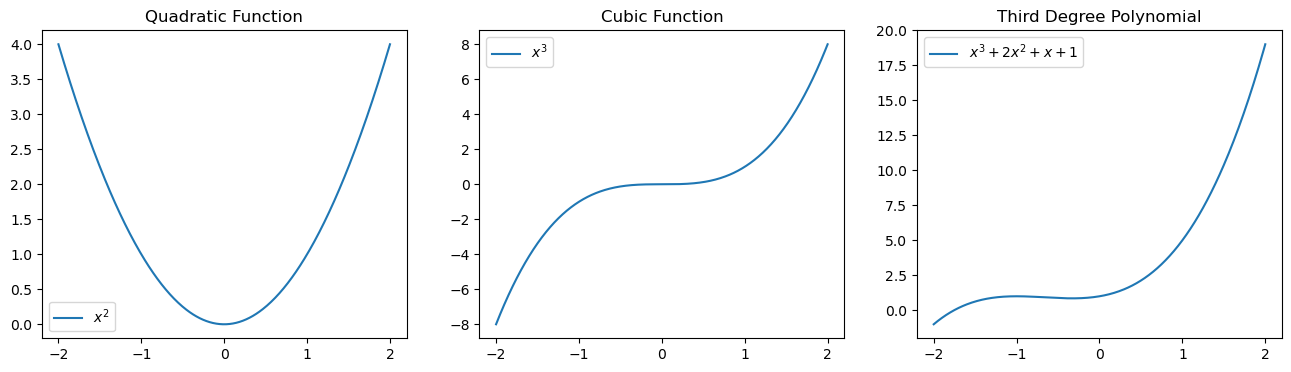

In [22]:
  import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")

plt.figure(figsize=(16,4))
x_vars = np.linspace(-2, 2, 400)

plt.subplot(131)  # Changed from '131' to 131
plt.title('Quadratic Function')
plt.plot(x_vars, x_vars**2)
plt.legend(["$x^2$"])

plt.subplot(132)  # Changed from '132' to 132
plt.title('Cubic Function')
plt.plot(x_vars, x_vars**3)
plt.legend(["$x^3$"])

plt.subplot(133)  # Changed from '133' to 133
plt.title('Third Degree Polynomial')
plt.plot(x_vars, x_vars**3 + 2*x_vars**2 + x_vars + 1)
plt.legend(["$x^3 + 2 x^2 + x + 1$"])

plt.show()


# Modeling Non-Linear Relationships With Polynomial Regression

<!-- Note that the set of $p$-th degree polynomials forms a linear model with parameters $a_p, a_{p-1}, ..., a_0$.
This means we can use our algorithms for linear models to learn non-linear features! -->

Specifically, given a one-dimensional continuous variable $x$, we can define the *polynomial feature* function $\phi : \mathbb{R} \to \mathbb{R}^{p+1}$ as
$$ \phi(x) = \begin{bmatrix}
1 \\
x \\
x^2 \\
\vdots \\
x^p
\end{bmatrix}.
$$

The class of models of the form
$$ f_\theta(x) := \sum_{j=0}^p \theta_p x^p = \theta^\top \phi(x) $$
with parameters $\theta$ and polynomial features $\phi$ is the set of $p$-degree polynomials.

* This model is non-linear in the input variable $x$, meaning that we can model complex data relationships.

* It is a linear model as a function of the parameters $\theta$, meaning that we can use our familiar ordinary least squares algorithm to learn these features.

# The UCI Diabetes Dataset

In this section, we are going to again use the UCI Diabetes Dataset.
* For each patient we have a access to a measurement of their body mass index (BMI) and a quantiative diabetes risk score (from 0-300). 
* We are interested in understanding how BMI affects an individual's diabetes risk.

Text(0, 0.5, 'Diabetes Risk')

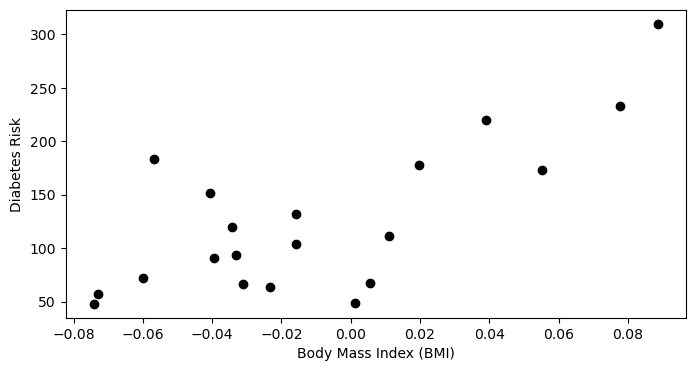

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]

import numpy as np
import pandas as pd
from sklearn import datasets

# Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)

# add an extra column of onens
X['one'] = 1

# Collect 20 data points
X_train = X.iloc[-20:]
y_train = y.iloc[-20:]

plt.scatter(X_train.loc[:,['bmi']], y_train,  color='black')
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Diabetes Risk')

# Diabetes Dataset: A Non-Linear Featurization

Let's now obtain linear features for this dataset.

In [24]:
X_bmi = X_train.loc[:, ['bmi']]

X_bmi_p3 = pd.concat([X_bmi, X_bmi**2, X_bmi**3], axis=1)
X_bmi_p3.columns = ['bmi', 'bmi2', 'bmi3']
X_bmi_p3['one'] = 1
X_bmi_p3.head()

bmi      bmi2      bmi3  one
422  0.077863  0.006063  0.000472    1
423 -0.039618  0.001570 -0.000062    1
424  0.011039  0.000122  0.000001    1
425 -0.040696  0.001656 -0.000067    1
426 -0.034229  0.001172 -0.000040    1

# Diabetes Dataset: A Polynomial Model

By training a linear model on this featurization of the diabetes set, we can obtain a polynomial model of diabetest risk as a function of BMI.

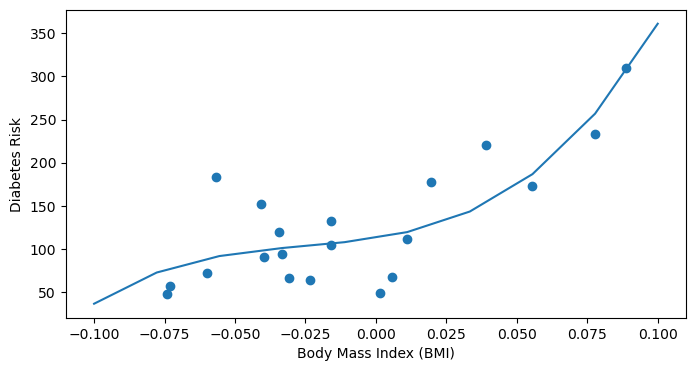

In [25]:
# Fit a linear regression
theta = np.linalg.inv(X_bmi_p3.T.dot(X_bmi_p3)).dot(X_bmi_p3.T).dot(y_train)

# Show the learned polynomial curve
x_line = np.linspace(-0.1, 0.1, 10)
x_line_p3 = np.stack([x_line, x_line**2, x_line**3, np.ones(10,)], axis=1)
y_train_pred = x_line_p3.dot(theta)

plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Diabetes Risk')
plt.scatter(X_bmi, y_train)
plt.plot(x_line, y_train_pred)

# Multivariate Polynomial Regression

We can construct non-linear functions of multiple variables by using multivariate polynomials.

For example, a polynomial of degree $2$ over two variables $x_1, x_2$ is a function of the form
<!-- $$
a_{20} x_1^2 + a_{10} x_1 + a_{02} x_2^2 + a_{01} x_2 + a_{22} x_1^2 x_2^2 + a_{21} x_1^2 x_2 + a_{12} x_1 x_2^2 + a_11 x_1 x_2 + a_{00}.
$$ -->
$$
a_{20} x_1^2 + a_{10} x_1 + a_{02} x_2^2 + a_{01} x_2 + a_{11} x_1 x_2 + a_{00}.
$$

In general, a polynomial of degree $p$ over two variables $x_1, x_2$ is a function of the form
$$
f(x_1, x_2) = \sum_{i,j \geq 0 : i+j \leq p} a_{ij} x_1^i x_2^j.
$$

In our two-dimensional example, this corresponds to a feature function $\phi : \mathbb{R}^2 \to \mathbb{R}^6$ of the form
$$ \phi(x) = \begin{bmatrix}
1 \\
x_1 \\
x_1^2 \\
x_2 \\
x_2^2 \\
x_1 x_2
\end{bmatrix}.
$$

The same approach can be used to specify polynomials of any degree and over any number of variables.

# Towards General Non-Linear Features

Any non-linear feature map $\phi(x) : \mathbb{R}^d \to \mathbb{R}^p$ can be used in this way to obtain general models of the form
$$ f_\theta(x) := \theta^\top \phi(x) $$
that are highly non-linear in $x$ but linear in $\theta$.

For example, here is a way of modeling complex periodic functions via a sum of sines and cosines.

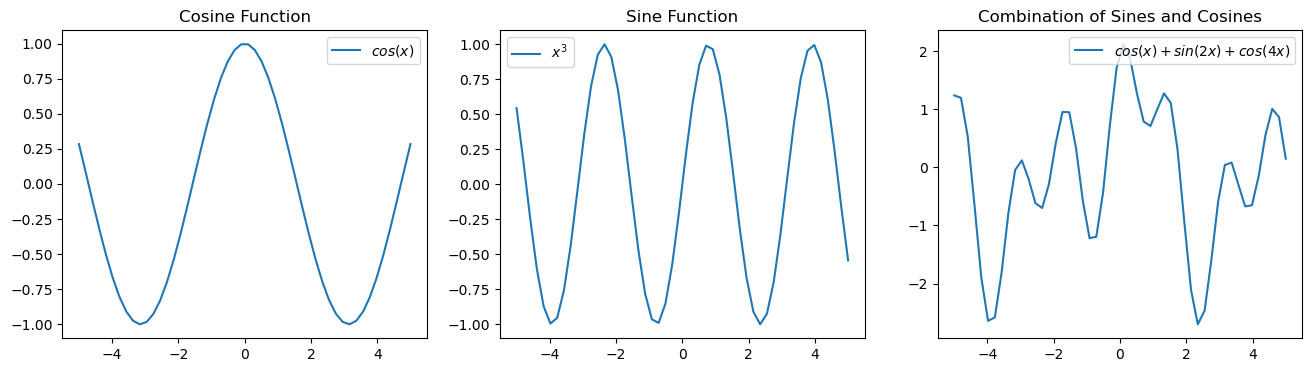

In [26]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(16,4))
x_vars = np.linspace(-5, 5)

plt.subplot(131)
plt.title('Cosine Function')
plt.plot(x_vars, np.cos(x_vars))
plt.legend(["$cos(x)$"])

plt.subplot(132)
plt.title('Sine Function')
plt.plot(x_vars, np.sin(2*x_vars))
plt.legend(["$x^3$"])

plt.subplot(133)
plt.title('Combination of Sines and Cosines')
plt.plot(x_vars, np.cos(x_vars) + np.sin(2*x_vars) + np.cos(4*x_vars))
plt.legend(["$cos(x) + sin(2x) + cos(4x)$"])